# Use lexicon-based sentiment to classify documents
In this example, we try to classify documents by exploiting lexicon-based sentiment scores combined with tfidf in order to vectorize documents.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Collect some data

In [2]:
import json

In [3]:
review_data_file = '../lexicon/data/yelp_sample.json'
with open(review_data_file, 'r') as infile:
    R = json.load(infile)

In [4]:
len(R)

10000

In [5]:
R[0]

{'content': "Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 'date': '2014-02-17',
 'stars': 4,
 'useful': 1,
 'funny': 0,
 'cool': 0,
 'business': 'Ue6-WhXvI-_1xUIuapl0zQ',
 'id': '----X0BIDP9tA49U3RvdSQ',
 'categories': ['American (Traditional)', 'Burgers', 'Restaurants']}

## Task: guess the number of stars for each review

In [6]:
target_values = set([doc['stars'] for doc in R])
target_values

{1, 2, 3, 4, 5}

## TfIdf Indexing

In [7]:
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

### Reduce number of documents and number of features

In [8]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [9]:
R = R[:4000]
lemmatized_docs = [] 
for text in tqdm(R):
    content = nlp(text['content'])
    tokens = []
    for sent in content.sents:
        for token in sent:
            if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'VERB', 'PNOUN'}:
                tokens.append(token.lemma_.lower())
    lemmatized_docs.append(" ".join(tokens))

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
lemmatized_docs[1]

'eat momo crawl good lot so decide eat restaurant mutton thali equally good'

In [11]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
X = vectorizer.fit_transform(lemmatized_docs).toarray() # dense to sparse
y = [x['stars'] for x in R]

In [12]:
features = vectorizer.get_feature_names_out()

In [13]:
features[100:110]

array(['3rd', '3star', '40', '400th', '40th', '45min', '45minute', '48th',
       '4\\/5', '4am'], dtype=object)

In [14]:
X.shape

(4000, 11345)

## Sentiment polarity

### SentiWordnet
In this example we just get the mean of polarities for all the synsets associated with a word.

In [15]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [16]:
def sentiwn_score(word):
    synsets = list(swn.senti_synsets(word))
    score = 0.0
    if len(synsets) > 0:
        polarity = pd.DataFrame([{'pos': sw.pos_score(), 
                                  'neg': sw.neg_score(), 
                                  'obj': sw.obj_score()} for sw in synsets])
        avg_polarity = polarity.mean()
        score = (avg_polarity['pos'] + avg_polarity['obj']) - (avg_polarity['neg'] + avg_polarity['obj'])
    return score

In [17]:
scores = []
for word in tqdm(features):
    scores.append(sentiwn_score(word))
scores = np.array(scores)

  0%|          | 0/11345 [00:00<?, ?it/s]

### Combine scores with TfIdf

In [18]:
Xsw = X * scores

### Vader
See [https://github.com/cjhutto/vaderSentiment](https://github.com/cjhutto/vaderSentiment).

Vader can be used either for scoring single words, or for getting a comprehensive score for the whole text document (i.e., `compound score`). In the folowing we see and example of sentence score evaluation.

In [19]:
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [21]:
analyzer = SentimentIntensityAnalyzer()
doc = R[0]['content']
for sent in sent_tokenize(doc):
    vs = analyzer.polarity_scores(sent)
    print(sent)
    print(vs)
    print('===============')

Red, white and bleu salad was super yum and a great addition to the menu!
{'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'compound': 0.8516}
This location was clean with great service and food served at just the right temps!
{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'compound': 0.7959}
Kids pizza is always a hit too with lots of great side dish options for the kiddos!
{'neg': 0.0, 'neu': 0.785, 'pos': 0.215, 'compound': 0.6588}
When I'm on this side of town, this will definitely be a spot I'll hit up again!
{'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'compound': 0.4574}


### TextBlob
See [https://textblob.readthedocs.io/en/dev/](https://textblob.readthedocs.io/en/dev/).

TextBlob is a NLP library that provides also some polarity facilities. Let's see an example.

In [22]:
from textblob import TextBlob

In [23]:
blob = TextBlob(R[0]['content'])
print(blob.tags)
print(blob.noun_phrases)

[('Red', 'NNP'), ('white', 'JJ'), ('and', 'CC'), ('bleu', 'JJ'), ('salad', 'NN'), ('was', 'VBD'), ('super', 'JJ'), ('yum', 'NN'), ('and', 'CC'), ('a', 'DT'), ('great', 'JJ'), ('addition', 'NN'), ('to', 'TO'), ('the', 'DT'), ('menu', 'NN'), ('This', 'DT'), ('location', 'NN'), ('was', 'VBD'), ('clean', 'JJ'), ('with', 'IN'), ('great', 'JJ'), ('service', 'NN'), ('and', 'CC'), ('food', 'NN'), ('served', 'VBD'), ('at', 'IN'), ('just', 'RB'), ('the', 'DT'), ('right', 'JJ'), ('temps', 'NN'), ('Kids', 'NNP'), ('pizza', 'NN'), ('is', 'VBZ'), ('always', 'RB'), ('a', 'DT'), ('hit', 'NN'), ('too', 'RB'), ('with', 'IN'), ('lots', 'NNS'), ('of', 'IN'), ('great', 'JJ'), ('side', 'JJ'), ('dish', 'NN'), ('options', 'NNS'), ('for', 'IN'), ('the', 'DT'), ('kiddos', 'NN'), ('When', 'WRB'), ('I', 'PRP'), ("'m", 'VBP'), ('on', 'IN'), ('this', 'DT'), ('side', 'NN'), ('of', 'IN'), ('town', 'NN'), ('this', 'DT'), ('will', 'MD'), ('definitely', 'RB'), ('be', 'VB'), ('a', 'DT'), ('spot', 'NN'), ('I', 'PRP'), ("'

In [24]:
for sent in blob.sentences:
    print(sent)
    print(sent.sentiment)
    print('===============')

Red, white and bleu salad was super yum and a great addition to the menu!
Sentiment(polarity=0.3333333333333333, subjectivity=0.35416666666666663)
This location was clean with great service and food served at just the right temps!
Sentiment(polarity=0.5079365079365079, subjectivity=0.6619047619047619)
Kids pizza is always a hit too with lots of great side dish options for the kiddos!
Sentiment(polarity=1.0, subjectivity=0.75)
When I'm on this side of town, this will definitely be a spot I'll hit up again!
Sentiment(polarity=0.0, subjectivity=0.5)


## Supervised classification (with SentiWn)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Xsw, y, random_state=42)

In [30]:
scls = RandomForestClassifier()
scls.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
y_pred = scls.predict(X_test)

In [32]:
y_pred[:10]

array([5, 5, 5, 5, 5, 1, 5, 1, 5, 5])

In [33]:
P = scls.predict_proba(X_test)
P.shape

(1000, 5)

In [34]:
np.round(P[0], 3)

array([0.06, 0.03, 0.08, 0.33, 0.5 ])

In [35]:
P.mean(axis=0)

array([0.15103, 0.06471, 0.09936, 0.23378, 0.45112])

### Evaluation

In [40]:
import matplotlib.pyplot as plt

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [42]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.58      0.52      0.55       146
           2       0.00      0.00      0.00        71
           3       0.50      0.01      0.02       116
           4       0.36      0.18      0.24       234
           5       0.54      0.93      0.68       433

    accuracy                           0.52      1000
   macro avg       0.39      0.33      0.30      1000
weighted avg       0.46      0.52      0.43      1000



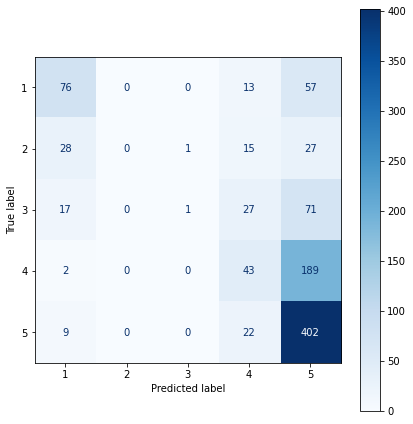

In [43]:
cm = confusion_matrix(y_test, y_pred, labels=list(range(1, 6)))
display = ConfusionMatrixDisplay(cm, display_labels=list(range(1, 6)))
fig, ax = plt.subplots(figsize=(6,6))
display.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()